## Water-related ecoystems
Change in extent of water-related ecosystems: open water and vegetated wetlands

In [1]:
import datacube
import geopandas as gpd
import numpy as np
import rasterio.mask
import rasterio.features
from shapely import geometry
import matplotlib.pyplot as plt
import sys
import xarray as xr
import numpy as np
import datetime
import pandas as pd

sys.path.append('../10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools, SpatialTools

dc = datacube.Datacube(app='tci and wofs')

../10_Scripts/DEAPlotting.py:23: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('agg')


### Import the coastline mask for removing open ocean from our dataset
Use the `GEODATA COAST 100K 2004` dataset (https://data.gov.au/dataset/geodata-coast-100k-2004) as a coarse approximation of the mean high water coastline to remove ocean from water layers
This is the mean high water mark (?)

<Figure size 432x288 with 0 Axes>

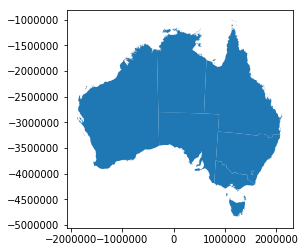

In [2]:
coastline_gpd = gpd.read_file('/g/data/r78/rt1527/datasets/Coastlines/australia/cstauscd_r.shp')
coastline_gpd = coastline_gpd.to_crs({'init': 'epsg:3577'})
coastline_gpd = coastline_gpd[(coastline_gpd.FEAT_CODE == 'island') | (coastline_gpd.FEAT_CODE == 'mainland')]
plt.clf()
coastline_gpd.plot()

### Load WOfS to get extent of open water
We have three test areas available in this notebook.
The areas are the Coorong/Murray Mouth, Mangroves in North-East QLD, and Menindee Lakes

In [3]:
resolution = 100

## Mangrove site
# query = dict(x=(149.84, 150.05),
#          y=(-22.14, -22.38),
#          resolution=(-resolution, resolution),
#          output_crs='EPSG:3577',
#          time=('2001-01-01', '2008-12-31'))

# ## Coorong
# query = dict(x=(138.75, 139.03), 
#              y=(-35.41, -35.59),
#              resolution=(-resolution, resolution),
#              output_crs='EPSG:3577',
#              time=('2001-01-01', '2019-01-01'))

# # Menindee
# query = dict(x=(143.92, 144.14), 
#              y=(-31.35, -31.53), 
#              resolution=(-resolution, resolution),
#              output_crs='EPSG:3577',
#              time=('2001-01-01', '2017-12-31'))

# Arafura swamp
query = dict(x=(134.867839, 135.251071), 
             y=(-12.430335, -12.729316), 
             resolution=(-resolution, resolution),
             output_crs='EPSG:3577',
             time=('2001-01-01', '2017-12-31'))

# Mangroves
wofs_ds = dc.load(product='wofs_annual_summary', **query)

# Set nodata
wofs_ds = wofs_ds.where(wofs_ds.frequency != -1)


In [4]:
# Create shoreline mask
coastline_mask = rasterio.features.geometry_mask(coastline_gpd.geometry,
                                                 out_shape=wofs_ds.geobox.shape,
                                                 transform=wofs_ds.geobox.affine,
                                                 all_touched=False, invert=True)

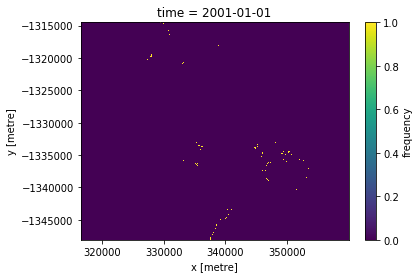

In [5]:
perm_water = (wofs_ds.frequency > 0.9).where(coastline_mask)
perm_water.isel(time=0).plot()

### calculate area of permanent open water per year

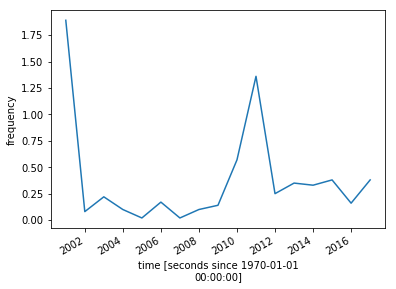

In [6]:
pixel_km2 = (resolution * resolution) / (1000 * 1000)
perm_water_sum =(perm_water.sum(dim=['x', 'y']) * pixel_km2)
perm_water_sum.plot()

## Load in all Landsat data

In [7]:
ls_data = DEADataHandling.load_clearlandsat(dc, 
                                            query, 
                                            sensors=('ls5', 'ls7', 'ls8'), 
                                            masked_prop=0,
                                            mask_pixel_quality=True)

Loading ls5 pixel quality
    Loading 130 filtered ls5 timesteps
Ignoring SLC-off observations for ls7
Loading ls7 pixel quality
    Loading 46 filtered ls7 timesteps
Loading ls8 pixel quality
    Loading 104 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### Make annual summaries of the wet and green tasselled cap data

In [8]:
# Define unique years to analyse
years = np.unique(ls_data.time.dt.year)

#make empty list to hold vegetated wetlands
tc_yearly = []

#calculate vegetated wetland extent per year
for year in years:
    
    print(year)
    
    #select data from each year
    year_data = ls_data.sel(time=ls_data['time.year']==year) 
    
    # Apply tasseled cap transformation 
    tc_data = TasseledCapTools.pct_exceedance_tasseled_cap(year_data)
    
    #calculate 90th percentile of tasselled cap
    tc_data_90th = xr.where(tc_data>0.9, 1, 0)
    
    #select areas where wetness and greenness are both in  the 90th percentile
    wet_veg = xr.where((tc_data_90th.greenness_pct_exceedance & tc_data_90th.wetness_pct_exceedance),1,0)
    
    # So we can plot the yearly data easily, re-add the time dimension to the wet veg array
    wet_veg['time'] = year
    wet_veg = wet_veg.expand_dims('time')
    
    # Append yearly result to list
    tc_yearly.append(wet_veg) 
    
    
    
#     # Prepare attributes as input to contour extract
#     attribute_data = {'year': [year]}
#     attribute_dtypes = {'year': 'float'}   

#     # Extract contours with custom attribute fields:
#     contour_dict = contour_extract(z_values=[0.9],
#                                    ds_array=tc_data,
#                                    ds_crs='epsg:3577',
#                                    ds_affine=ls_data.geobox.transform,
#                                    output_shp='output_shp/contour_{}.shp'.format(year),
#                                    attribute_data=attribute_data,
#                                    attribute_dtypes=attribute_dtypes)    

    
    
# # Combine all shapefiles into one file
# shapefiles = glob.glob('relative_topography/{}_*.shp'.format(name))
# gdf = pd.concat([gpd.read_file(shp) for shp in shapefiles], sort=False).pipe(gpd.GeoDataFrame)

# # Save as combined shapefile
# gdf = gdf.reset_index()[['in_perc', 'geometry']].sort_values('in_perc')
# gdf.crs = 'epsg:3577'
# gdf.to_file(f'relative_topography/{name}_combined.shp')

# # Plot contours
# fig, ax = plt.subplots(figsize=(16, 16))
# gdf.plot(ax=ax, column='in_perc', cmap='viridis')

    

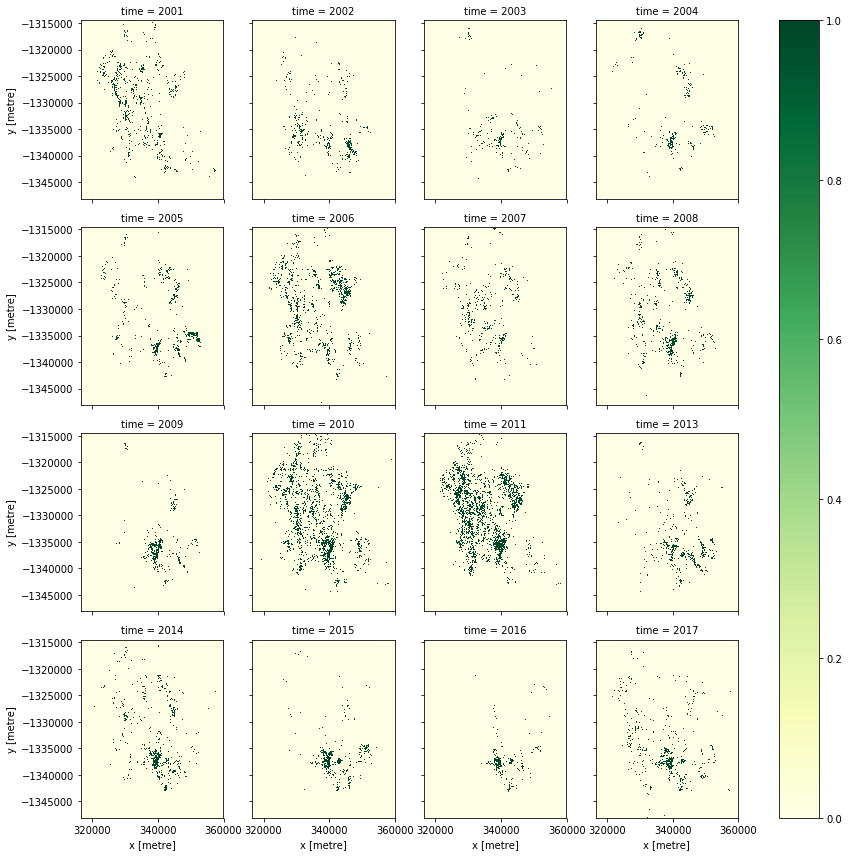

In [10]:
# Combine all individual years into one xarray dataset
wet_veg_yearly = xr.concat(tc_yearly, dim='time') 

# Plot multiple years of data
wet_veg_yearly.plot(col='time', col_wrap=4, cmap='YlGn')

In [11]:
sdg_661_df= wet_veg_yearly.sum(dim=['x', 'y']).to_dataframe(name='perm_wetveg_pixels')
sdg_661_df['perm_wetveg_km2'] = sdg_661_df['perm_wetveg_pixels'] * pixel_km2
sdg_661_df = sdg_661_df.drop(columns='perm_wetveg_pixels')
sdg_661_df['perm_openwater_km2'] = perm_water_sum[perm_water_sum['time.year'].isin(years)] 
sdg_661_df

,perm_wetveg_km2,perm_openwater_km2
time,,
2001,33.34,1.89
2002,19.45,0.08
2003,9.88,0.22
2004,13.13,0.10
2005,22.35,0.02
2006,45.62,0.17
2007,19.99,0.02
2008,27.05,0.10
2009,15.94,0.14


In [115]:
sdg_661_df['perm_wetveg_change'] = np.round(((sdg_661_df['perm_wetveg_km2'] / sdg_661_df.mean(axis=0)[0]) * 100), 1)
sdg_661_df['perm_openwater_change'] = np.round(((sdg_661_df['perm_openwater_km2'] / sdg_661_df.mean(axis=0)[1]) * 100), 1)

In [116]:
sdg_661_df

,perm_wetveg_km2,perm_openwater_km2,perm_wetveg_change,perm_openwater_change
time,,,,
2001,33.34,1.89,108.0,482.3
2002,19.45,0.08,63.0,20.4
2003,9.88,0.22,32.0,56.1
2004,13.13,0.10,42.5,25.5
2005,22.35,0.02,72.4,5.1
2006,45.62,0.17,147.7,43.4
2007,19.99,0.02,64.7,5.1
2008,27.05,0.10,87.6,25.5
2009,15.94,0.14,51.6,35.7


Text(0, 0.5, 'Percent change vs mean conditions')

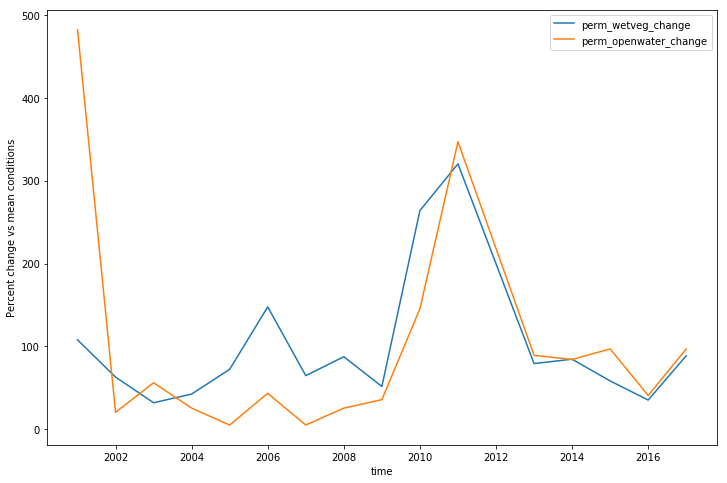

In [111]:
ax = sdg_661_df[['perm_wetveg_change', 'perm_openwater_change']].plot(figsize=(12,8))
ax.set_ylabel(ylabel='Percent change vs mean conditions')

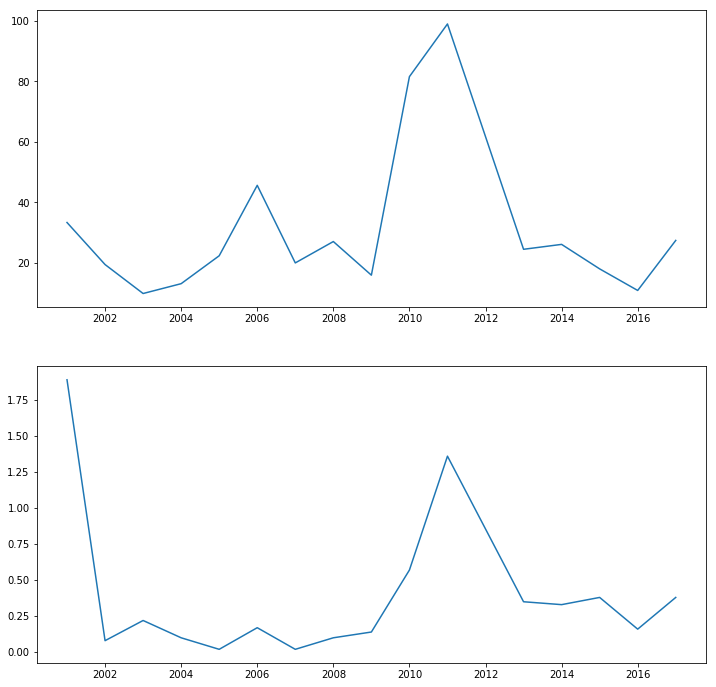

In [17]:
fig, axes = plt.subplots(2,1, figsize=(12, 12))
axes[0].plot(sdg_661_df['perm_wetveg_km2'])
axes[1].plot(sdg_661_df['perm_openwater_km2'])


Text(0, 0.5, 'Open water (km2)')

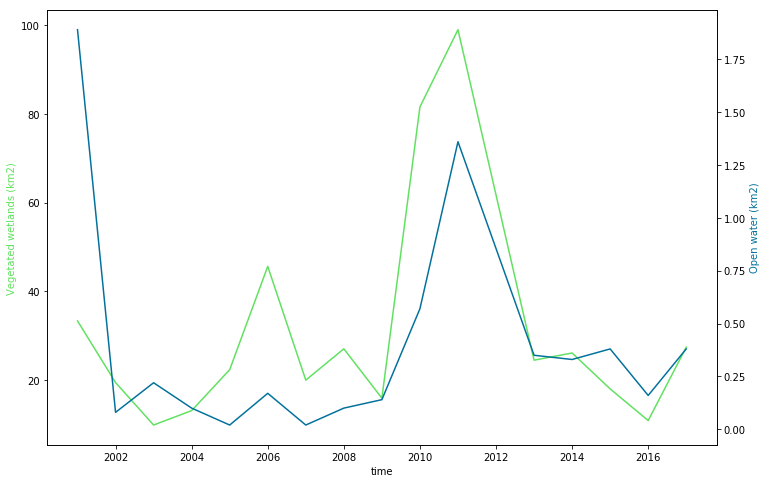

In [29]:
ax1 = sdg_661_df['perm_wetveg_km2'].plot(color='xkcd:lightish green', figsize=(12,8))
ax1.set_ylabel(ylabel='Vegetated wetlands (km2)', color='xkcd:lightish green')

ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
sdg_661_df['perm_openwater_km2'].plot(ax=ax2, color='xkcd:ocean blue')
ax2.set_ylabel(ylabel='Open water (km2)', color='xkcd:ocean blue')

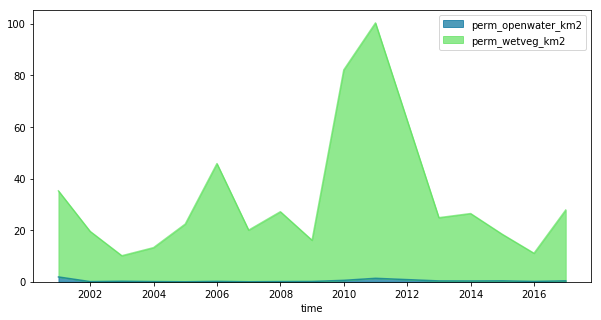

In [30]:
sdg_661_df[['perm_openwater_km2', 'perm_wetveg_km2']].plot.area(figsize=(10, 5), color=['xkcd:ocean blue', 'xkcd:lightish green'], alpha=0.7)

## Plot one timestep

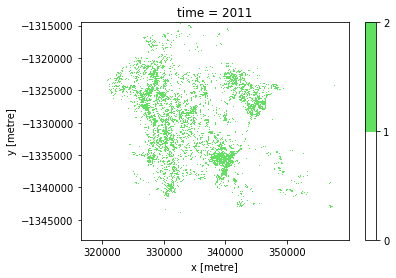

In [55]:
wet_veg_yearly.sel(time=2011).plot(colors=['white', 'xkcd:lightish green'], levels=[0,1,2])

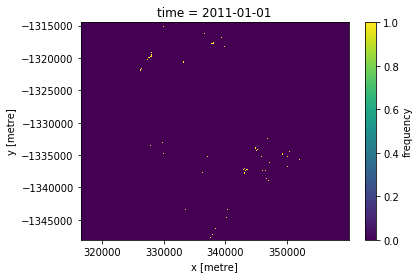

In [64]:
perm_water.isel(time=10).plot()

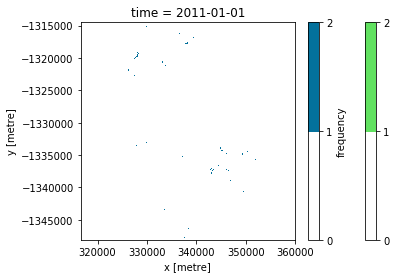

In [68]:
wet_veg_yearly.sel(time=2011).plot.pcolormesh(colors=['white', 'xkcd:lightish green'], levels=[0,1,2])
perm_water.isel(time=10).plot.pcolormesh(colors=['white', 'xkcd:ocean blue'], levels=[0,1,2])

In [75]:
combo = ((perm_water.isel(time=10))*3)+wet_veg_yearly.sel(time=2011)

Text(0.5, 1.0, 'Arafura swamp persistent open water and wet vegetation 2011')

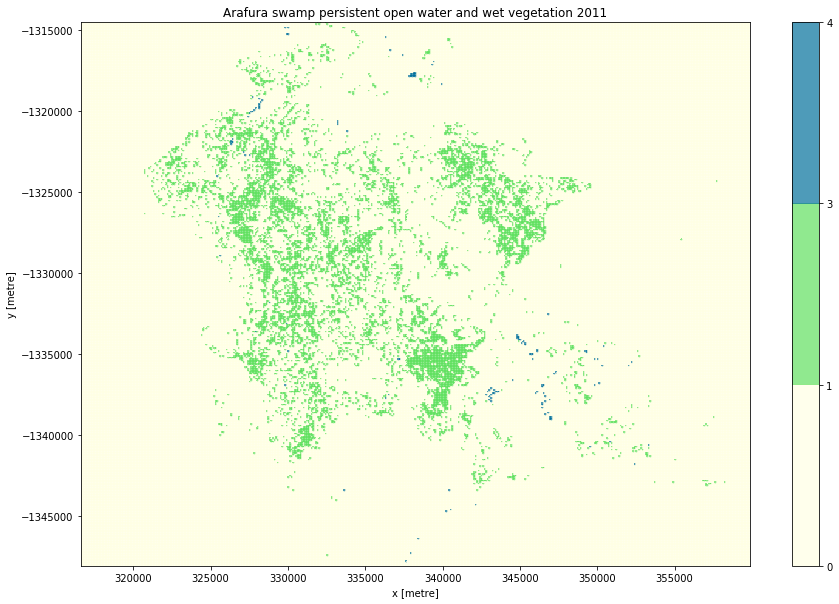

In [90]:
combo.plot.pcolormesh(colors=['xkcd:off white', 'xkcd:lightish green',  'xkcd:ocean blue'],alpha =0.7, levels=[0,1,3,4], size=10)#, cbar=False)
plt.title("Arafura swamp persistent open water and wet vegetation 2011")